In [5]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
import geopandas as gpd
import random
from haversine import haversine

### 1. 부평동

In [58]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][121]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[168653.14777371 541614.36745629]
 [170275.85798985 542555.51827977]
 [169169.71110429 541212.96545304]
 [168454.84152943 542199.91798198]
 [168882.50515437 541473.80099055]
 [169571.68144261 543170.68772603]
 [169017.13448131 542296.80671238]
 [168487.40637655 541751.70879128]
 [168041.15992457 541728.01992404]
 [168987.75881339 541585.92737811]
 [168260.60000044 541938.63091751]
 [168795.30218088 541706.78336727]
 [170902.08277901 542103.40677481]
 [168617.45718606 541662.96560117]
 [169741.73721145 543014.42815733]
 [169090.51247164 541606.2943631 ]
 [168735.49081132 542477.17358734]
 [168767.38410275 541271.3409708 ]
 [169173.9877233  541590.68238235]
 [168393.34691861 541798.04803131]
 [169226.60371608 542225.27998594]
 [168111.50181112 541617.45267894]
 [168874.89185872 542372.07592286]
 [168495.20078656 541608.15518024]
 [169348.17616523 542779.49062223]
 [169175.53743198 542120.36828047]
 [170249.85139191 542548.5970901 ]
 [169101.83868135 541855.2994675

In [8]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df

In [10]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\USER\AppData\Local\Temp\ipykernel_14136\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

                경도             위도   latitude   longitude
0    175798.314457  541304.120368  37.470851  126.726411
1    174886.047151  542132.705742  37.478292  126.716070
2    176041.264676  544028.539131  37.495404  126.729068
3    174744.871699  543312.225761  37.488916  126.714433
4    175824.495106  543477.717906  37.490436  126.726635
..             ...            ...        ...         ...
195  175957.438507  543097.663260  37.487015  126.728151
196  175918.377379  545062.019950  37.504713  126.727645
197  176169.836204  543812.649227  37.493462  126.730529
198  175852.781108  545102.811328  37.505079  126.726902
199  175261.845918  543476.133050  37.490407  126.720273

[200 rows x 4 columns]


c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\USER\AppData\Local\Temp\ipykernel_14136\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

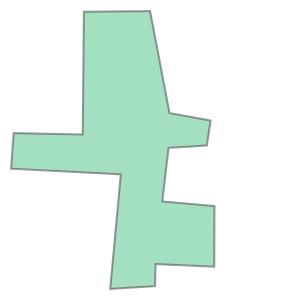

In [22]:
ex= path+'상습침수구역.shx'
gpff= gpd.read_file(ex)
gpff['geometry'][20]

In [12]:
# 아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='부평동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

In [ ]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='부평동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


In [22]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='부평동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points


In [29]:
# 가중치 도보+자전거 0.601  버스 0.311, 0.088 지하철 
m1= 0.311
m2= 0.088
m3= 0.601

In [36]:
def mclp(버스_points, 지하철_points,주택_points, K, radius):

    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(sites_df['latitude'], sites_df['longitude'])])
    J = sites.shape[0]                             
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주택_points.shape[0]
    
    # 입지후보지와 수요지점 간 거리 계산
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D2.append(site)
    D2 = np.array(D2)    
    

    
    D3 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D3.append(site)
    D3 = np.array(D3)

    for i in [D1, D2, D3]:
        mask1 = i<=radius
        i[mask1]=1                                                 
        i[~mask1]=0

    m = Model()
    x1, x2, x3 = {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    
    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K) 

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    
    # 목적함수 수정
    m.setObjective(quicksum(i for i in [m1*x1[a] for a in range(A)] + [m2*x2[b] for b in range(B)]  + [m3*x3[c] for c in range(C)]), GRB.MAXIMIZE)


    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [37]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 3, 1500)
opts_sites

  K 3
  Radius 1500
----- Output -----
  Running time : 0.36499619483947754 seconds
Optimal coverage points: 238.914


array([[ 37.48481212, 126.72681298],
       [ 37.50510849, 126.72298304],
       [ 37.50569085, 126.72503846]])

### 만수동

In [70]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][2]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 1000  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
시도 횟수: 1000, 유효한 사이트 수: 406
시도 횟수: 2000, 유효한 사이트 수: 824
[[175881.9276196  539350.88744238]
 [175886.63385059 539723.23201156]
 [176299.37446592 539558.04930629]
 ...
 [176678.63856612 537708.59074942]
 [176766.18901993 541317.75152617]
 [176392.07057989 538933.31181201]]


In [94]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [95]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\USER\AppData\Local\Temp\ipykernel_14136\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

                경도             위도   latitude   longitude
0    175881.927620  539350.887442  37.453255  126.727420
1    175886.633851  539723.232012  37.456609  126.727461
2    176299.374466  539558.049306  37.455132  126.732131
3    176970.724683  538727.329228  37.447664  126.739745
4    176008.130064  541264.737930  37.470502  126.728784
..             ...            ...        ...         ...
995  175672.908539  539510.627607  37.454688  126.725052
996  176117.834572  540237.397473  37.461248  126.730057
997  176678.638566  537708.590749  37.438478  126.736476
998  176766.189020  541317.751526  37.470999  126.737352
999  176392.070580  538933.311812  37.449505  126.733199

[1000 rows x 4 columns]


c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\USER\AppData\Local\Temp\ipykernel_14136\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

In [96]:
#아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='만수동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.44921966, 126.73295724],
       [ 37.45169949, 126.72648214],
       [ 37.45167541, 126.72677636],
       [ 37.45164405, 126.72707508],
       [ 37.45198231, 126.72749947],
       [ 37.46429623, 126.72313986],
       [ 37.43847555, 126.73717716],
       [ 37.45753859, 126.72485995],
       [ 37.44053721, 126.73959107],
       [ 37.44984664, 126.7392879 ],
       [ 37.4498875 , 126.73915775],
       [ 37.45843344, 126.73199056],
       [ 37.46253137, 126.73677108],
       [ 37.46386839, 126.73693583],
       [ 37.46358827, 126.73752636],
       [ 37.46395892, 126.7381234 ],
       [ 37.4644785 , 126.73833264],
       [ 37.46500354, 126.73853845],
       [ 37.46041175, 126.72832213],
       [ 37.46064217, 126.73010409],
       [ 37.46317302, 126.73127027],
       [ 37.46190307, 126.73758886],
       [ 37.46253751, 126.72409277],
       [ 37.46336014, 126.72453225],
       [ 37.45034383, 126.73391319],
       [ 37.44247487, 126.73497372],
       [ 37.44273797, 126.73494006],
 

In [98]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='만수동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.44817192, 126.73663642],
       [ 37.45496238, 126.73190368]])

In [99]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='만수동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.4394167, 126.7368   ],
       [ 37.4397   , 126.73785  ],
       [ 37.4422167, 126.73855  ],
       [ 37.4422833, 126.7388833],
       [ 37.4433167, 126.7362833],
       [ 37.4435333, 126.7366   ],
       [ 37.4457333, 126.7327833],
       [ 37.4445   , 126.7389167],
       [ 37.4446167, 126.7386333],
       [ 37.44675  , 126.7328167],
       [ 37.4483   , 126.7306667],
       [ 37.4486333, 126.7305   ],
       [ 37.4491667, 126.7294833],
       [ 37.4481667, 126.7331833],
       [ 37.44585  , 126.74055  ],
       [ 37.4485   , 126.7329   ],
       [ 37.4460167, 126.7407667],
       [ 37.4495833, 126.7297   ],
       [ 37.44805  , 126.7348   ],
       [ 37.4483833, 126.7349833],
       [ 37.4472167, 126.73985  ],
       [ 37.4504833, 126.7296167],
       [ 37.45045  , 126.7297833],
       [ 37.4474333, 126.7397333],
       [ 37.4490833, 126.7343667],
       [ 37.4479333, 126.7381833],
       [ 37.4482667, 126.7382667],
       [ 37.4517333, 126.72715  ],
       [ 37.4518667,

In [101]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 3, 1500)
opts_sites

  K 3
  Radius 1500
----- Output -----
  Running time : 0.841529369354248 seconds
Optimal coverage points: 111.948


array([[ 37.44479803, 126.73450284],
       [ 37.45331705, 126.73279458],
       [ 37.45357067, 126.74002646]])

### 구월동

In [105]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][43]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 1000  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
시도 횟수: 1000, 유효한 사이트 수: 485
시도 횟수: 2000, 유효한 사이트 수: 950
[[173704.59940187 537914.85919888]
 [175222.85237004 539259.28219382]
 [173519.05854499 538751.31130814]
 ...
 [174815.87275905 538023.03836928]
 [174604.59122249 537956.15169087]
 [174350.52562317 539070.68640999]]


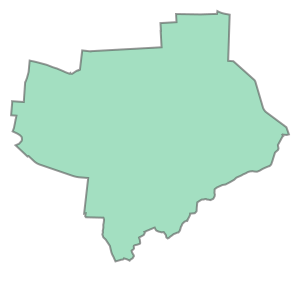

In [104]:
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][43]

In [106]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [107]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\USER\AppData\Local\Temp\ipykernel_14136\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

                경도             위도   latitude   longitude
0    173704.599402  537914.859199  37.440257  126.702863
1    175222.852370  539259.282194  37.452412  126.719974
2    173519.058545  538751.311308  37.447788  126.700737
3    174937.961398  538868.669429  37.448885  126.716768
4    173524.989681  539000.073964  37.450029  126.700795
..             ...            ...        ...         ...
995  174313.428948  539296.372770  37.452721  126.709695
996  174711.342349  538217.919113  37.443015  126.714229
997  174815.872759  538023.038369  37.441262  126.715417
998  174604.591222  537956.151691  37.440654  126.713032
999  174350.525623  539070.686410  37.450689  126.710122

[1000 rows x 4 columns]


C:\Users\USER\AppData\Local\Temp\ipykernel_14136\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(proj_UTM, proj_WGS84, x, y)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_cr

In [108]:
#아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='구월동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.4566462 , 126.72081939],
       [ 37.44955346, 126.71542014],
       [ 37.44826398, 126.72634881],
       [ 37.44833368, 126.72645672],
       [ 37.45301304, 126.70222306],
       [ 37.45347627, 126.70346765],
       [ 37.45345996, 126.70368632],
       [ 37.45293643, 126.70378799],
       [ 37.45264418, 126.7054278 ],
       [ 37.45284296, 126.70615405],
       [ 37.45509593, 126.71218014],
       [ 37.45453808, 126.71685375],
       [ 37.45823601, 126.72057763],
       [ 37.4540115 , 126.69947504],
       [ 37.45068312, 126.70509462],
       [ 37.45143157, 126.70410879],
       [ 37.45153487, 126.70410413],
       [ 37.45170389, 126.70508025],
       [ 37.45246428, 126.70519083],
       [ 37.45491113, 126.7025913 ],
       [ 37.44125818, 126.7106041 ],
       [ 37.44654835, 126.7109302 ],
       [ 37.44743469, 126.71335475],
       [ 37.44009148, 126.7136059 ],
       [ 37.44038259, 126.71617506],
       [ 37.44206128, 126.7134263 ],
       [ 37.44408413, 126.7133959 ],
 

In [109]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='구월동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.44944591, 126.70116335],
       [ 37.45587968, 126.71951424],
       [ 37.45678003, 126.71049663]])

In [110]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='구월동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.44195  , 126.7028667],
       [ 37.4443167, 126.69785  ],
       [ 37.4459833, 126.6945167],
       [ 37.4460833, 126.6939833],
       [ 37.44295  , 126.7044333],
       [ 37.4432   , 126.7049667],
       [ 37.4444333, 126.7071   ],
       [ 37.44455  , 126.7066833],
       [ 37.4487   , 126.7007   ],
       [ 37.4490833, 126.7011   ],
       [ 37.4475833, 126.7070667],
       [ 37.4480167, 126.7076   ],
       [ 37.4492833, 126.7125333],
       [ 37.4497   , 126.7120833],
       [ 37.4520667, 126.7077667],
       [ 37.4543833, 126.7085   ],
       [ 37.4553333, 126.70825  ],
       [ 37.4566   , 126.7048333],
       [ 37.4520667, 126.7208833],
       [ 37.4522   , 126.72125  ],
       [ 37.45215  , 126.7221   ],
       [ 37.4519667, 126.7228333],
       [ 37.45345  , 126.7188833],
       [ 37.4534333, 126.7192833],
       [ 37.4566333, 126.7106667],
       [ 37.45695  , 126.7102667],
       [ 37.4562667, 126.71405  ],
       [ 37.4565333, 126.7141167],
       [ 37.4558833,

In [112]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 3, 1500)
opts_sites

  K 3
  Radius 1500
----- Output -----
  Running time : 0.7950398921966553 seconds
Optimal coverage points: 105.026


array([[ 37.44555657, 126.7166313 ],
       [ 37.45186638, 126.71018386],
       [ 37.44317186, 126.70970027]])

### 간석동

In [115]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][49]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 1000  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
시도 횟수: 1000, 유효한 사이트 수: 409
시도 횟수: 2000, 유효한 사이트 수: 803
[[174640.89636526 541392.86611642]
 [173545.80736929 539560.18112326]
 [172838.08417702 540907.44512117]
 ...
 [172779.92312398 540763.89026594]
 [174577.89426676 539825.76794184]
 [173340.4767236  540959.74832822]]


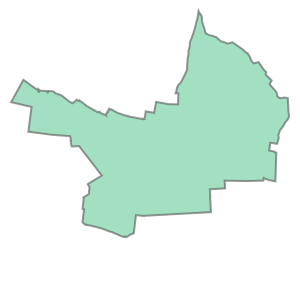

In [116]:
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][49]

In [117]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [118]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\USER\AppData\Local\Temp\ipykernel_14136\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

                경도             위도   latitude   longitude
0    174640.896365  541392.866116  37.471620  126.713324
1    173545.807369  539560.181123  37.455076  126.701010
2    172838.084177  540907.445121  37.467195  126.692962
3    174339.448556  541019.593470  37.468248  126.709929
4    172844.360009  541145.164682  37.469337  126.693024
..             ...            ...        ...         ...
995  174958.230105  540782.769366  37.466131  126.716932
996  173646.644302  539982.531119  37.458885  126.702134
997  172779.923124  540763.890266  37.465900  126.692309
998  174577.894267  539825.767942  37.457498  126.712665
999  173340.476724  540959.748328  37.467681  126.698639

[1000 rows x 4 columns]


c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\USER\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\USER\AppData\Local\Temp\ipykernel_14136\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

In [119]:
#아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='간석동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.4644432 , 126.71549018],
       [ 37.46748368, 126.69107789],
       [ 37.4590903 , 126.71063339],
       [ 37.4648583 , 126.70561062],
       [ 37.46574995, 126.7062016 ],
       [ 37.46595872, 126.70649677],
       [ 37.46771823, 126.70750814],
       [ 37.45820194, 126.69780422],
       [ 37.45783225, 126.69960336],
       [ 37.45570854, 126.69969079],
       [ 37.45697012, 126.7028436 ],
       [ 37.4569756 , 126.70305454],
       [ 37.46336308, 126.69925968],
       [ 37.46091579, 126.70276318],
       [ 37.46661897, 126.69215269],
       [ 37.46775777, 126.69338287],
       [ 37.46702692, 126.69435576],
       [ 37.46762166, 126.68940604],
       [ 37.46219386, 126.69744916],
       [ 37.45893423, 126.70711027],
       [ 37.46514812, 126.69492   ],
       [ 37.46702432, 126.69868313],
       [ 37.46802921, 126.70844893],
       [ 37.46800508, 126.70966971],
       [ 37.46602641, 126.71515183],
       [ 37.46117063, 126.70991055],
       [ 37.46352297, 126.70927141],
 

In [120]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='간석동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.46664592, 126.70816108],
       [ 37.4574194 , 126.70234212],
       [ 37.45688086, 126.70130161]])

In [121]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='간석동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.4572833, 126.6949833],
       [ 37.4575833, 126.6948   ],
       [ 37.4570833, 126.697    ],
       [ 37.45735  , 126.6972   ],
       [ 37.4569333, 126.69875  ],
       [ 37.4572   , 126.6991333],
       [ 37.4568833, 126.7047667],
       [ 37.4674167, 126.6904   ],
       [ 37.4675667, 126.6899833],
       [ 37.4614667, 126.7189333],
       [ 37.4619167, 126.7186667],
       [ 37.4615167, 126.7204333],
       [ 37.4636667, 126.7152333],
       [ 37.46395  , 126.7138167],
       [ 37.4622667, 126.7201667],
       [ 37.46535  , 126.71105  ],
       [ 37.4625167, 126.7206167],
       [ 37.4657167, 126.7110667],
       [ 37.4671667, 126.7064167],
       [ 37.4674833, 126.7065167],
       [ 37.4641667, 126.7205   ],
       [ 37.46365  , 126.7208333],
       [ 37.4695833, 126.7081667],
       [ 37.4741333, 126.7094167],
       [ 37.4763   , 126.7099333],
       [ 37.4759   , 126.7136   ],
       [ 37.47665  , 126.71255  ],
       [ 37.4680667, 126.72085  ],
       [ 37.4734833,

In [122]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 3, 1500)
opts_sites

  K 3
  Radius 1500
----- Output -----
  Running time : 0.7890627384185791 seconds
Optimal coverage points: 113.268


array([[ 37.46313679, 126.7055686 ],
       [ 37.46847502, 126.69892157],
       [ 37.46839978, 126.70393318]])